**Load packages**

In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn.metrics import accuracy_score, confusion_matrix

sns.set()
PATH="../input/" 

**Load data**

In [2]:
X_train_df = pd.read_csv(PATH+"/X_train.csv")
X_test_df = pd.read_csv(PATH+"/X_test.csv")
Y_train_df = pd.read_csv(PATH+"/y_train.csv")
target = pd.read_csv(PATH+'/y_train.csv')
sub = pd.read_csv(PATH+"/sample_submission.csv")

# Feature Engineering

In [3]:
def fe(data):
    df = pd.DataFrame()
    data['totl_anglr_vel'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 + data['angular_velocity_Z']**2)** 0.5
    data['totl_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 + data['linear_acceleration_Z']**2)**0.5
    data['totl_xyz'] = (data['orientation_X']**2 + data['orientation_Y']**2 + data['orientation_Z']**2)**0.5
    data['acc_vs_vel'] = data['totl_linr_acc'] / data['totl_anglr_vel']
    
    def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_median'] = data.groupby(['series_id'])[col].median()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_range'] = df[col + '_max'] - df[col + '_min']
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_mean_abs_chg'] = data.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        df[col + '_mean_change_of_abs_change'] = data.groupby('series_id')[col].apply(mean_change_of_abs_change)
        df[col + '_abs_max'] = data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        df[col + '_abs_min'] = data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2
    return df

train_df = fe(X_train_df)
test_df = fe(X_test_df)
print ("New features: ",train_df.shape[1])
display(train_df.head())

New features:  168


,orientation_X_mean,orientation_X_median,orientation_X_max,orientation_X_min,orientation_X_std,orientation_X_range,orientation_X_maxtoMin,orientation_X_mean_abs_chg,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,orientation_X_abs_min,orientation_X_abs_avg,orientation_Y_mean,orientation_Y_median,orientation_Y_max,orientation_Y_min,orientation_Y_std,orientation_Y_range,orientation_Y_maxtoMin,orientation_Y_mean_abs_chg,orientation_Y_mean_change_of_abs_change,orientation_Y_abs_max,orientation_Y_abs_min,orientation_Y_abs_avg,orientation_Z_mean,orientation_Z_median,orientation_Z_max,orientation_Z_min,orientation_Z_std,orientation_Z_range,orientation_Z_maxtoMin,orientation_Z_mean_abs_chg,orientation_Z_mean_change_of_abs_change,orientation_Z_abs_max,orientation_Z_abs_min,orientation_Z_abs_avg,orientation_W_mean,orientation_W_median,orientation_W_max,orientation_W_min,...,totl_anglr_vel_mean_change_of_abs_change,totl_anglr_vel_abs_max,totl_anglr_vel_abs_min,totl_anglr_vel_abs_avg,totl_linr_acc_mean,totl_linr_acc_median,totl_linr_acc_max,totl_linr_acc_min,totl_linr_acc_std,totl_linr_acc_range,totl_linr_acc_maxtoMin,totl_linr_acc_mean_abs_chg,totl_linr_acc_mean_change_of_abs_change,totl_linr_acc_abs_max,totl_linr_acc_abs_min,totl_linr_acc_abs_avg,totl_xyz_mean,totl_xyz_median,totl_xyz_max,totl_xyz_min,totl_xyz_std,totl_xyz_range,totl_xyz_maxtoMin,totl_xyz_mean_abs_chg,totl_xyz_mean_change_of_abs_change,totl_xyz_abs_max,totl_xyz_abs_min,totl_xyz_abs_avg,acc_vs_vel_mean,acc_vs_vel_median,acc_vs_vel_max,acc_vs_vel_min,acc_vs_vel_std,acc_vs_vel_range,acc_vs_vel_maxtoMin,acc_vs_vel_mean_abs_chg,acc_vs_vel_mean_change_of_abs_change,acc_vs_vel_abs_max,acc_vs_vel_abs_min,acc_vs_vel_abs_avg
series_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.758530,-0.75822,-0.75953,0.000363,0.00131,0.998275,0.000015,2.380952e-07,0.75953,0.75822,0.758875,-0.634008,-0.634270,-0.63306,-0.63456,0.000471,0.00150,0.997636,0.000018,0.000000e+00,0.63456,0.63306,0.633810,-0.105474,-0.105500,-0.104610,-0.106140,0.000432,0.001530,0.985585,0.000051,7.936508e-08,0.106140,0.104610,0.105375,-0.106470,-0.106555,-0.105590,-0.107050,...,0.000067,0.162384,0.010603,0.086494,9.939676,10.077860,12.575577,7.117152,0.989642,5.458424,1.766939,0.689030,0.006324,12.575577,7.117152,9.846364,0.994316,0.994306,0.994413,0.994253,0.000042,0.000160,1.000161,0.000006,7.240501e-08,0.994413,0.994253,0.994333,223.282937,187.471573,995.561076,56.133014,135.641510,939.428062,17.735749,114.896199,1.309785,995.561076,56.133014,525.847045
1,-0.958606,-0.958595,-0.95837,-0.95896,0.000151,0.00059,0.999385,0.000023,-4.761905e-07,0.95896,0.95837,0.958665,0.241867,0.241890,0.24270,0.24074,0.000499,0.00196,1.008142,0.000070,1.587302e-07,0.24270,0.24074,0.241720,0.031650,0.031688,0.032341,0.030504,0.000508,0.001837,1.060222,0.000048,3.253968e-07,0.032341,0.030504,0.031423,-0.146876,-0.146910,-0.145870,-0.148090,...,-0.001095,0.287947,0.020167,0.154057,10.082444,10.069950,16.986332,5.867993,1.826016,11.118339,2.894743,1.361058,-0.018901,16.986332,5.867993,11.427163,0.989155,0.989150,0.989305,0.988974,0.000077,0.000331,1.000334,0.000016,-2.398138e-07,0.989305,0.988974,0.989139,118.973908,98.477877,611.826712,32.938319,88.488750,578.888393,18.574922,57.943094,0.508448,611.826712,32.938319,322.382516
2,-0.512057,-0.512035,-0.50944,-0.51434,0.001377,0.00490,0.990473,0.000041,0.000000e+00,0.51434,0.50944,0.511890,-0.846171,-0.846210,-0.84490,-0.84779,0.000785,0.00289,0.996591,0.000024,-7.142857e-07,0.84779,0.84490,0.846345,-0.129371,-0.129405,-0.128520,-0.130300,0.000541,0.001780,0.986339,0.000059,-1.746032e-06,0.130300,0.128520,0.129410,-0.071082,-0.071139,-0.070378,-0.071535,...,-0.000471,0.170919,0.009871,0.090395,10.035741,10.082289,12.725500,6.794325,0.944637,5.931175,1.872960,0.711678,-0.001612,12.725500,6.794325,9.759913,0.997471,0.997467,0.997515,0.997438,0.000020,0.000078,1.000078,0.000004,-1.068346e-07,0.997515,0.997438,0.997477,190.13423

**Filling missing NAs and infinite data ∞  by zeroes 0**

In [4]:
train_df.fillna(0, inplace = True)
train_df.replace(-np.inf, 0, inplace = True)
train_df.replace(np.inf, 0, inplace = True)
test_df.fillna(0, inplace = True)
test_df.replace(-np.inf, 0, inplace = True)
test_df.replace(np.inf, 0, inplace = True)

**Standarization**

In [5]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(train_df))
X_test_scaled = pd.DataFrame(scaler.transform(test_df))
X_train_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167
0,-1.080161,-1.079898,-1.089366,-1.071550,-0.601727,-0.599121,-0.021421,-0.658087,0.320344,0.455900,0.490939,0.473909,-1.001245,-1.001569,-1.010113,-0.991812,-0.565439,-0.571679,-0.023780,-0.625298,0.015239,-0.102595,-0.057877,-0.080044,-1.112937,-1.113125,-1.120509,-1.103174,-0.506429,-0.561239,-0.016587,-0.531159,0.093718,0.162439,0.200247,0.181548,-0.984416,-0.985289,-0.991948,-0.973604,...,0.110298,-0.828980,-0.519549,-0.808956,-0.438068,-0.138938,-0.506246,0.380762,-0.542346,-0.501756,-0.450044,-0.563804,0.346558,-0.506246,0.380762,-0.477901,-0.055780,-0.058710,-0.070205,-0.031780,-0.517863,-0.536448,-0.536751,-0.435900,0.553191,-0.070205,-0.031780,-0.050778,0.265845,0.283442,0.143058,0.063600,0.176173,0.146469,-0.113058,0.328904,0.434328,0.143058,0.063600,0.139838
1,-1.371767,-1.371667,-1.381118,-1.362565,-0.634918,-0.632274,-0.021024,-0.608125,-0.614629,1.159574,1.182335,1.171828,0.235538,0.235553,0.227341,0.243307,-0.560947,-0.549754,-0.009432,-0.303394,0.193113,-1.531669,-1.457922,-1.495349,0.181123,0.181503,0.172285,0.185607,-0.422277,-0.461943,0.057252,-0.569790,0.310939,-1.548991,-1.500975,-1.525783,-1.371850,-1.372237,-1.378102,-1.367066,...,-1.985190,-0.328703,-0.460865,-0.435543,-0.264644,-0.153011,0.139224,-0.167213,0.015843,0.154509,-0.193142,0.057404,-1.025177,0.139224,-0.167213,0.105154,-1.395270,-1.396747,-1.412234,-1.384291,-0.044975,0.101798,0.106778,0.615510,-1.604895,-1.412234,-1.384291,-1.398817,-0.098028,-0.098567,-0.075991,-0.166719,-0.045048,-0.069773,-0.084434,-0.031030,0.176977,-0.075991,-0.166719,-0.081564
2,-0.720492,-0.720416,-0.726728,-0.713761,-0.442364,-0.433818,-0.024209,-0.504431,0.008686,-0.409235,-0.368445,-0.388873,-1.300831,-1.300824,-1.309444,-1.292697,-0.514383,-0.505429,-0.025207,-0.587312,-0.785193,0.675033,0.698102,0.687131,-1.338451,-1.338713,-1.346215,-1.331043,-0.386707,-0.480379,-0.015841,-0.394443,-1.517920,0.722719,0.749139,0.736441,-0.645099,-0.645704,-0.654379,-0.633113,...,-0.860744,-0.794975,-0.524041,-0.787394,-0.321376,-0.131055,-0.484306,0.239146,-0.572382,-0.446941,-0.425894,-0.542869,-0.085028,-0.484306,0.239146,-0.509787,0.762893,0.761582,0.744711,0.784130,-0.811615,-0.845474,-0.846069,-0.631787,-0.685730,0.744711,0.784130,0.765066,0.150209,0.108287,0.090946,0.030849,0.162793,0.093693,-0.134230,0.132875,-0.011580,0.090946,0.030849,0.088373
3,-1.343418,-1.343338,-1.352650,-1.334431,-0.622987,-0.620762,-0.021124,-0.593042,-0.822400,1.091546,1.114871,1.104041,0.331943,0.331885,0.324513,0.340235,-0.568385,-0.545941,-0.011547,-0.513776,0.015239,-1.280872,-1.212793,-1.247259,0.250059,0.249453,0.242687,0.255571,-0.487298,-0.449005,0.046641,-0.294226,-0.719108,-1.376037,-1.330683,-1.354062,-1.328158,-1.330047,-1.315500,-1.331401,...,-2.564965,0.610081,-0.495970,0.199770,0.713997,1.369603,0.702189,-1.835827,0.867582,1.041608,1.446434,0.835892,-3.613862,0.702189,-1.835827,0.113122,-1.222779,-1.229836,-1.165890,-1.243069,1.557698,1.549777,1.557993,1.955596,-3.886422,-1.165890,-1.243069,-1.205591,-0.111420,-0.158983,0.034807,-0.381534,0.066499,0.059617,1.713603,0.087973,0.311775,0.034807,-0.381534,0.012270
4,-1.273604,-1.273001,-1.276691,-1.271991,-0.194575,-0.191620,-0.024852,-0.269705,0.112572,0.940564,0.934862,0.938286,0.498571,0.499558,0.502453,0.491263,0.360620,0.354866,0.048121,0.281973,0.282050,-0.821618,-0.830842,-0.826807,0.449196,0.449741,0.450099,0.447269,0.102862,0.083699,0.057529,-0.798319,0.051676,-0.866497,-0.864090,-0.865810,-1.271984,-1.272995,-1.277537,-1.263811,...,0.003527,-0.553448,-0.023915,-0.394632,-0.494992,-0.267474,-0.665770,0.799502,-0.692162,-0.738833,-0.528406,-0.718486,-0.066969,-0.665770,0.799502,-0.502897,-1.008525,-1.011737,-1.020391,-0.987214,-0.081395,-0.116338,-0.113672,

**Label Encoding**

In [6]:
le = LabelEncoder()
target['surface'] = le.fit_transform(target['surface'])
target.head()

,series_id,group_id,surface
0,0,13,2
1,1,31,1
2,2,20,1
3,3,31,1
4,4,22,6


# LightGBM

In [7]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=59)

In [8]:
data = X_train_scaled
test = X_test_scaled

In [9]:
predicted = np.zeros((test.shape[0],9))
measured = np.zeros((data.shape[0]))
score = 0

### SUFFLE + BOOTSTRAP

In [10]:
# https://www.kaggle.com/jiweiliu/lgb-2-leaves-augment#500381
def shuffle_col_vals(x1):
    rand_x = np.array([np.random.choice(x1.shape[0], size=x1.shape[0], replace=False) for i in range(x1.shape[1])]).T
    grid = np.indices(x1.shape)
    rand_y = grid[1]
    return x1[(rand_x, rand_y)]

def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        x1 = shuffle_col_vals(x1)
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        x1 = shuffle_col_vals(x1)
        xn.append(x1)

    xs = np.vstack(xs); xn = np.vstack(xn)
    ys = np.ones(xs.shape[0]);yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn]); y = np.concatenate([y,ys,yn])
    
    return x,y

In [11]:
for times, (trn_idx, val_idx) in enumerate(folds.split(data.values,target['surface'].values)):
    lgb_train = lgb.Dataset(data.iloc[trn_idx], label=target['surface'][trn_idx])
    lgb_val = lgb.Dataset(data.iloc[val_idx], label=target['surface'][val_idx])
    params = {
    'objective': 'multiclass',
    'metric': 'multi_error', 
    "num_class": 9,
    'nthread': -1
    }

    model = lgb.train(params, lgb_train, 500, valid_sets=[lgb_train, lgb_val], early_stopping_rounds=100, verbose_eval=-1)
    
    measured[val_idx] = [np.argmax(x) for x in model.predict(data.iloc[val_idx])]
    predicted += model.predict(test)/folds.n_splits
    score += (1 - model.best_score['valid_1']['multi_error'])
    print("Fold: {} score: {}".format(times, (1 - model.best_score['valid_1']['multi_error'])))

#     importances = model.feature_importances
#     indices = np.argsort(importances)
#     features = data.columns
#     
#     if model.score(data.iloc[val_idx],target['surface'][val_idx]) > 0.9500:
#         hm = 30
#         plt.figure(figsize=(7, 10))
#         plt.title('Feature Importances')
#         plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='b', align='center')
#         plt.yticks(range(len(indices[:hm])), [features[i] for i in indices])
#         plt.xlabel('Relative Importance')
#         plt.show()

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[55]	training's multi_error: 0	valid_1's multi_error: 0.0961039
Fold: 0 score: 0.9038961038961039
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[53]	training's multi_error: 0	valid_1's multi_error: 0.140625
Fold: 1 score: 0.859375
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[54]	training's multi_error: 0	valid_1's multi_error: 0.125326
Fold: 2 score: 0.8746736292428199
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[49]	training's multi_error: 0	valid_1's multi_error: 0.109948
Fold: 3 score: 0.8900523560209423
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[51]	training's multi_error: 0	valid_1's multi_error: 0.11811
Fold: 4 score: 0.8818897637795275
Training until validation scores do

Avg Accuracy RF 0.8777009831803456


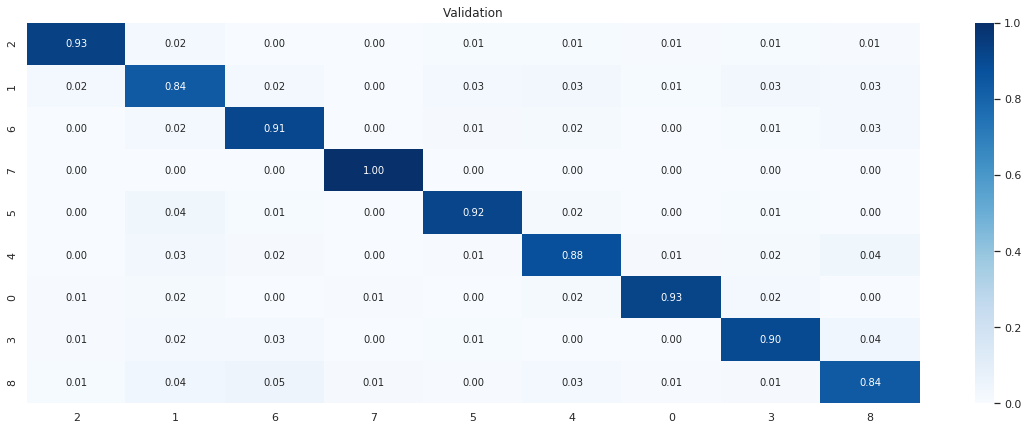

In [12]:
print('Avg Accuracy RF', score / folds.n_splits)
Y_val_max = measured
val_pred = target['surface']
labels_names = target['surface'].unique()
cnf_matrix = confusion_matrix(Y_val_max, val_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Validation')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

**Submission**

In [13]:
test_sub = [np.argmax(x) for x in model.predict(test)]
sub['surface'] = le.inverse_transform(test_sub)
sub.to_csv('submission.csv', index=False)
sub.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,carpet
2,2,tiled
3,3,soft_tiles
4,4,soft_tiles
